# Export Ratio 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
from mpl_toolkits.basemap import Basemap

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [5]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [6]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [7]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [8]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)

ds= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## plot the fraction of NPP lost to sinking (export ratio)

In [9]:
ds.NO3

<xarray.DataArray 'NO3' (time: 12, z_t: 60, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 60, 384, 320), dtype=float32, chunksize=(1, 60, 384, 320)>
Coordinates:
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Dissolved Inorganic Nitrate
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [10]:
e_ratio_s = ds.POC_PROD.isel(z_t=slice(None,10)).sum(dim=['z_t','nlat','nlon']) / \
            ds.photoC_TOT.isel(z_t_150m=slice(None,10)).sum(dim=['z_t_150m','nlat','nlon']) 

Text(0.5, 1.0, 'e-ratio (over top 100 m)')

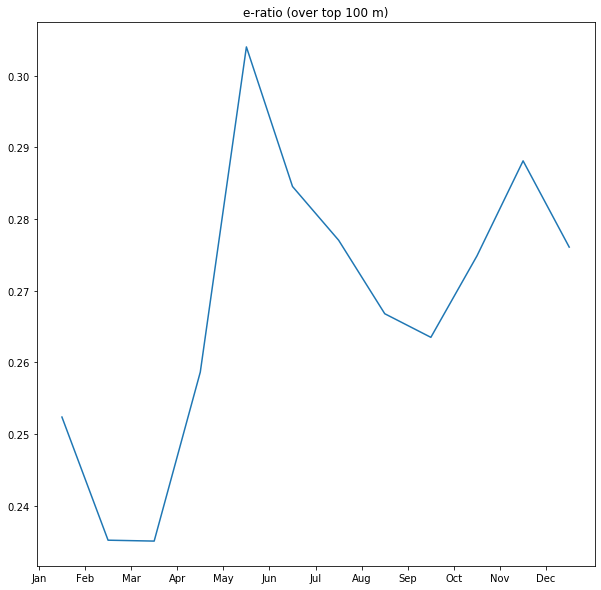

In [11]:
month = np.arange(1,13,1)
fig = plt.figure(figsize=(10, 10))
plt.plot(month,e_ratio_s.values)
plt.xticks(np.arange(0.5,12.5,1), ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title("e-ratio (over top 100 m)")

In [12]:
e_ratio =  ds.POC_PROD.isel(z_t=slice(None,10)).sum(dim=['z_t'])/ ds.photoC_TOT.isel(z_t_150m=slice(None,10)).sum(dim=['z_t_150m'])
prod = ds.POC_PROD.isel(z_t=slice(None,10)).sum(dim=['z_t'])
npp = ds.photoC_TOT.isel(z_t_150m=slice(None,10)).sum(dim=['z_t_150m'])

## Production, NPP and E-ratio
(NPP) = the Gross Primary Production (GPP) minus Respiration (R)
e-ratio should be the export production over net primary production

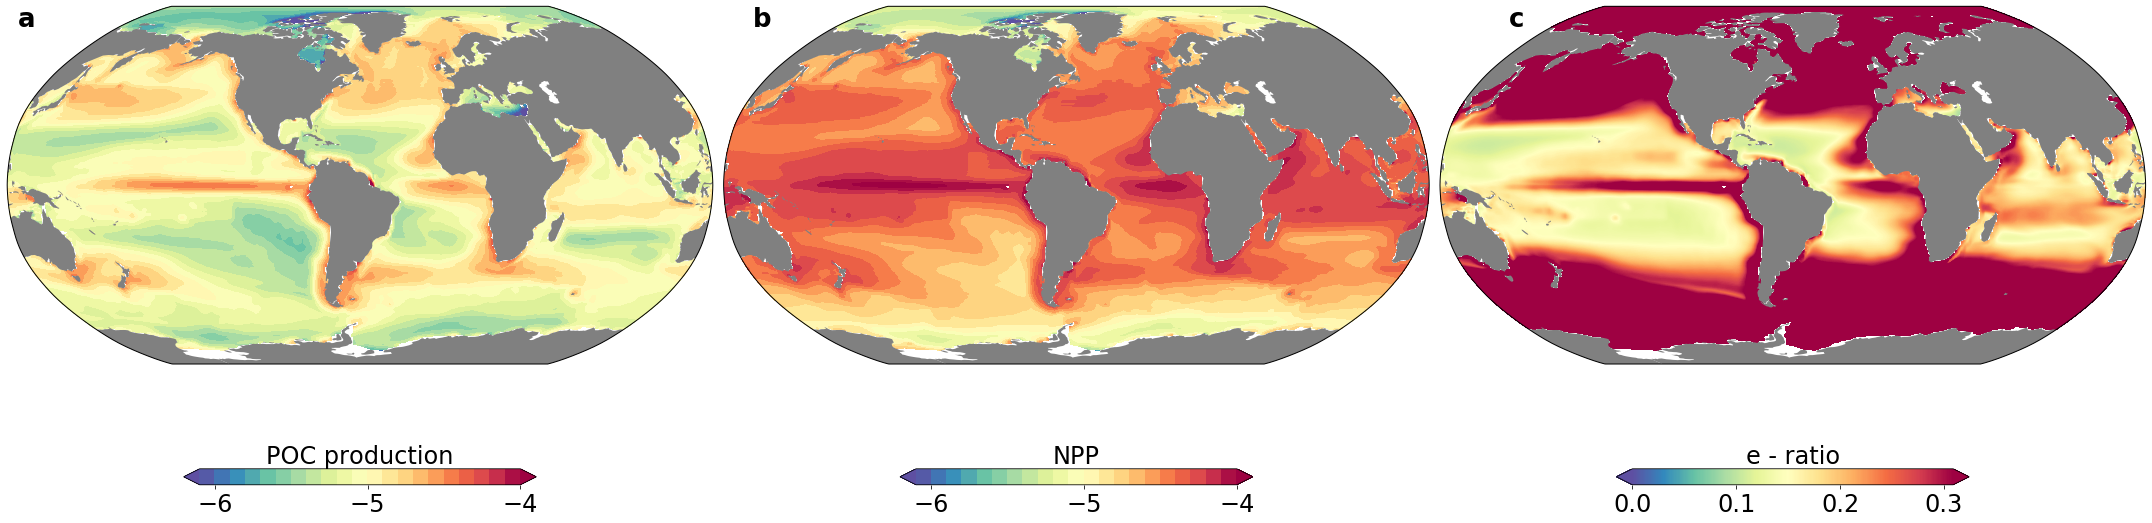

In [13]:
fig = plt.figure(figsize=(30, 10))

lev = np.arange(-6.1, -3.9, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(prod.mean(dim=['time'])))
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-6,-5,-4],shrink=0.5, orientation='horizontal')
cb.ax.set_title('POC production', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(-6.1, -3.9, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(npp.mean(dim=['time'])))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-6,-5,-4],shrink=0.5, orientation='horizontal')
cb.ax.set_title('NPP', fontsize = 24)
cb.ax.tick_params(labelsize=24)


lev = np.arange(0, 0.31, 0.001)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=.15)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, prod.mean(dim=['time'])/npp.mean(dim=['time']))
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5, ticks=[0,0.1,0.2,0.3], orientation='horizontal')
cb.ax.set_title('e - ratio', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/e-ratio'+new_file+'.png',dpi=600, bbox_inches='tight')

#### If I wanted to find the individual POC export ratios or POC export for each phytoplankton, i don't think I necessarely could. the ds.POC_PROD is not divided into individual phytoplankton, and I guess I could use the individual ppC as a proxy, but would that make sense? do let's say ds.ppC/ds.photoC_pp_zint_100m. That could potentially be anoter way to do this!! 

# Let's do this plot for the Arctic Ocean now though! 

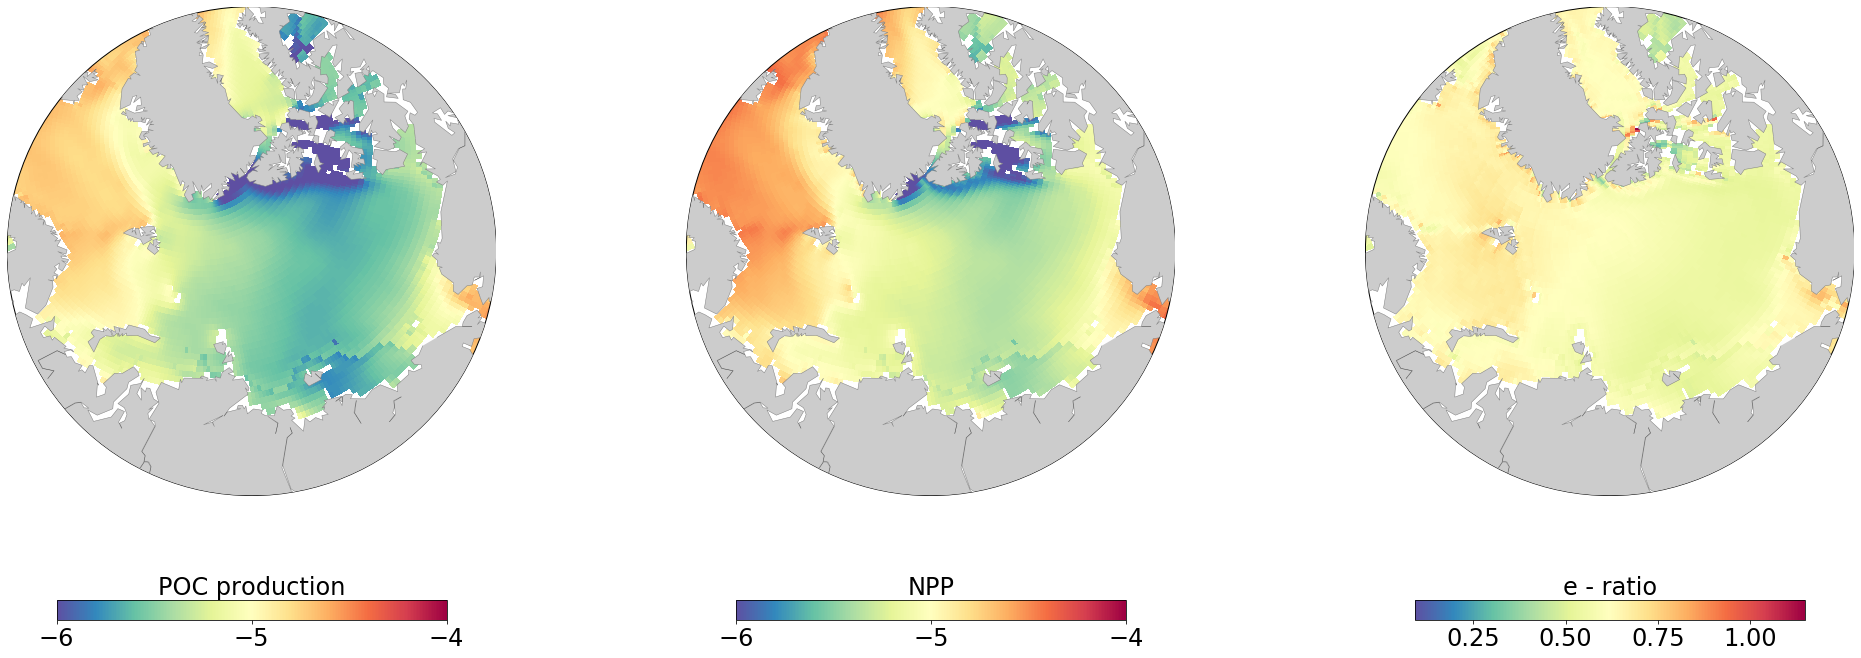

In [14]:
fig = plt.figure(figsize=(30, 10))


lev = np.arange(-6.1, -3.9, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(prod.mean(dim=['time'])))
x, y = m(lon,lat)
ax = fig.add_subplot(1, 3, 1)
cf = m.pcolormesh(x,y,zoo,cmap='Spectral_r', vmin = -6, vmax = -4)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[-6,-5,-4],shrink=0.5, orientation='horizontal')
cb.ax.set_title('POC production', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(-6.1, -3.9, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.log10(npp.mean(dim=['time'])))
x, y = m(lon,lat)
ax = fig.add_subplot(1, 3, 2)
cf = m.pcolormesh(x,y,zoo,cmap='Spectral_r', vmin = -6, vmax = -4)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf, ticks=[-6,-5,-4],shrink=0.5, orientation='horizontal')
cb.ax.set_title('NPP', fontsize = 24)
cb.ax.tick_params(labelsize=24)

lev = np.arange(0, 0.31, 0.001)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=.15)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, prod.mean(dim=['time'])/npp.mean(dim=['time']))
x, y = m(lon,lat)
ax = fig.add_subplot(1, 3, 3)
cf = m.pcolormesh(x,y,zoo,cmap='Spectral_r')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf,shrink=0.5, orientation='horizontal')
cb.ax.set_title('e - ratio', fontsize = 24)
cb.ax.tick_params(labelsize=24)
#fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
#fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
#fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/e-ratio_AO'+new_file+'.png',dpi=600, bbox_inches='tight')

In [15]:
ds

<xarray.Dataset>
Dimensions:                           (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 12, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
    transport_components              (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    TLONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    transport_regions                 (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
  * moc_z                             (moc_z) float32 0.0 1000.0 ... 549999.06
  * z_w_top                   